# Felipe Cardona - Tarea 2 - Regresión, KNN y GBM

## Importar dependencias necesarias.

In [33]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [35]:
# Cargar los datos desde el archivo CSV
data = pd.read_csv("data/training_pruebas.csv", low_memory=False)

## Punto 1. Regression

### Lectura y carga de los datos
### Debido a la cantidad de que posee el dataset utilizaremos el atributo low_memory al momento de leer el excel con el fin de evitarnos problemas al cargar el dataset por primera vez.

### Punto 1.1: Exploración de datos - Análisis inicial
Empezaremos mostrando los datos que tiene el dataset y la estadistica descriptiva basica. Puesto que aun es complicado saber que datos decidiremos eliminar esto lo haremos mas adelante.

In [36]:
# Punto 1.1: Exploración de datos - Análisis inicial
data.info()  # Ver estructura y tipos de datos
print(data.describe())  # Estadísticas descriptivas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111430 entries, 0 to 111429
Data columns (total 78 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ESTU_TIPODOCUMENTO              111430 non-null  object 
 1   ESTU_NACIONALIDAD               111430 non-null  object 
 2   ESTU_GENERO                     111430 non-null  object 
 3   ESTU_FECHANACIMIENTO            111430 non-null  object 
 4   ESTU_EXTERIOR                   111430 non-null  object 
 5   PERIODO                         111430 non-null  int64  
 6   ESTU_CONSECUTIVO                111430 non-null  object 
 7   ESTU_ESTUDIANTE                 111430 non-null  object 
 8   ESTU_PAIS_RESIDE                111430 non-null  object 
 9   ESTU_DEPTO_RESIDE               111430 non-null  object 
 10  ESTU_COD_RESIDE_DEPTO           111430 non-null  int64  
 11  ESTU_MCPIO_RESIDE               111430 non-null  object 
 12  ESTU_COD_RESIDE_

### Para poder optimizar el recorrido en los datos y obtener mejores cálculos, se consideró necesario realizar el punto 3 en este momento. Por lo tanto, eliminaremos las variables que no son relevantes. En caso de ser necesario eliminaremos más variables más adelante.

In [37]:
columnsToDrop = [
    'ESTU_CONSECUTIVO', 'INST_COD_INSTITUCION', 'ESTU_SNIES_PRGMACADEMICO', 'ESTU_MCPIO_RESIDE', 
    'ESTU_COD_RESIDE_MCPIO', 'ESTU_INST_MUNICIPIO', 'ESTU_MCPIO_PRESENTACION', 'ESTU_PRESENTACIONCASA', 
    'ESTU_CURSOIESAPOYOEXTERNO','ESTU_CURSOIESEXTERNA', 'ESTU_SIMULACROTIPOICFES','ESTU_FECHANACIMIENTO',
    'ESTU_TIPODOCUMENTO', 'ESTU_NUCLEO_PREGRADO', 'ESTU_NUCLEO_PREGRADO_1', 'ESTU_ESTUDIANTE'
]
dataCleaned = data.drop(columns=columnsToDrop, errors='ignore') # Eliminar las columnas del DataFrame
print(dataCleaned.head())

  ESTU_NACIONALIDAD ESTU_GENERO ESTU_EXTERIOR  PERIODO ESTU_PAIS_RESIDE  \
0          COLOMBIA           M            NO    20231         COLOMBIA   
1          COLOMBIA           M            NO    20231         COLOMBIA   
2          COLOMBIA           F            NO    20231         COLOMBIA   
3          COLOMBIA           F            NO    20231         COLOMBIA   
4          COLOMBIA           F            NO    20231         COLOMBIA   

  ESTU_DEPTO_RESIDE  ESTU_COD_RESIDE_DEPTO     ESTU_AREARESIDE  \
0         ATLANTICO                      8  Cabecera Municipal   
1            CALDAS                     17  Cabecera Municipal   
2            TOLIMA                     73  Cabecera Municipal   
3        LA GUAJIRA                     44  Cabecera Municipal   
4             VALLE                     76  Cabecera Municipal   

  ESTU_ESTADOCIVIL ESTU_TITULOOBTENIDOBACHILLER  ...  \
0          Soltero          Bachiller académico  ...   
1          Soltero          Bachiller ac

### Justificación del por que eliminar estas variables categoricas.

Se decidieron eliminar las siguientes variables debido a 4 agrupaciones o justificaciones en este caso. Esto basado en la exploración inicial desarrollada y en la descripción del dataset que se brinda en la [competencia](https://www.kaggle.com/competitions/pruebas-saber/data).


*Identificadores y Consecutivos:*

- ESTU_CONSECUTIVO: Identificador único del estudiante.
- INST_COD_INSTITUCION, ESTU_SNIES_PRGMACADEMICO: Códigos numéricos para instituciones y programas.
*Ubicación demasiado específica o redundante:*

- ESTU_MCPIO_RESIDE y ESTU_COD_RESIDE_MCPIO: Usamos ESTU_DEPTO_RESIDE en su lugar.
- ESTU_INST_MUNICIPIO: Municipio exacto de la institución, preferimos el departamento.
- ESTU_MCPIO_PRESENTACION: Municipio de presentación, reemplazable por ESTU_DEPTO_PRESENTACION.

*Categorías vacías o con pocos datos:*

- ESTU_PRESENTACIONCASA: Solo 2 valores no nulos.
- ESTU_CURSOIESAPOYOEXTERNO, ESTU_CURSOIESEXTERNA, ESTU_SIMULACROTIPOICFES: La mayoría de sus valores son nulos.

*Formato no adecuado y Detalles innecesarios:*

- ESTU FECHANACIMIENTO: Debido al fomato que tiene no aporta gran valor predicitivo (Aclaro que este dato se tocara mas adelante con el fin de manejarlo de mejor forma pero de momento queda descartado).
- ESTU_TIPODOCUMENTO: No aporta valor predictivo relevante.

*Información académica poco relevante:*

- ESTU_NUCLEO_PREGRADO, ESTU_NUCLEO_PREGRADO_1: Descripciones muy específicas que pueden no ser útiles.
- ESTU_ESTUDIANTE: Valor redundante sin variación.

## 1.2: Valores nulos para variables cuantitativas 
Entre los valores nulos encontrados esta la columna ESTU_NSE_INDIVIDUAL y ESTU_NSE_IES.

Debido a los valores obtenidos anterioremente del conjunto de datos y al comportamiento de estos, se decide imputar por la mediana.
Entre la justificación esta:
- La media es mayor que la mediana, lo que sugiere asimetría.
- La desviación estándar indica variabilidad en los datos.

In [38]:
print(dataCleaned.isnull().sum())
# En base a los valores nulos que tenemos vamos a imputarlos usando la medianada (utilizamos la que obtuvimos arriba).
dataCleaned.fillna(2.000000, inplace=True)

ESTU_NACIONALIDAD              0
ESTU_GENERO                    0
ESTU_EXTERIOR                  0
PERIODO                        0
ESTU_PAIS_RESIDE               0
                            ... 
PUNT_GLOBAL                    0
ESTU_INSE_INDIVIDUAL        3925
ESTU_NSE_INDIVIDUAL         3925
ESTU_NSE_IES                   0
ESTU_ESTADOINVESTIGACION       0
Length: 62, dtype: int64


### 1.3: Crear variables dummy para variables categóricas relevantes

In [39]:
categoricalCols = dataCleaned.select_dtypes(include=['object']).columns # Seleccionar columnas categóricas (tipo 'object')
print(f"Columnas categóricas: {list(categoricalCols)}")

Columnas categóricas: ['ESTU_NACIONALIDAD', 'ESTU_GENERO', 'ESTU_EXTERIOR', 'ESTU_PAIS_RESIDE', 'ESTU_DEPTO_RESIDE', 'ESTU_AREARESIDE', 'ESTU_ESTADOCIVIL', 'ESTU_TITULOOBTENIDOBACHILLER', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_PAGOMATRICULABECA', 'ESTU_PAGOMATRICULACREDITO', 'ESTU_PAGOMATRICULAPADRES', 'ESTU_PAGOMATRICULAPROPIO', 'ESTU_COMOCAPACITOEXAMENSB11', 'ESTU_CURSODOCENTESIES', 'ESTU_ACTIVIDADREFUERZOAREAS', 'ESTU_ACTIVIDADREFUERZOGENERIC', 'ESTU_TIPODOCUMENTOSB11', 'ESTU_SEMESTRECURSA', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE', 'FAMI_OCUPACIONPADRE', 'FAMI_OCUPACIONMADRE', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENELAVADORA', 'FAMI_TIENEHORNOMICROOGAS', 'FAMI_TIENESERVICIOTV', 'FAMI_TIENEAUTOMOVIL', 'FAMI_TIENEMOTOCICLETA', 'FAMI_TIENECONSOLAVIDEOJUEGOS', 'FAMI_TRABAJOLABORPADRE', 'FAMI_TRABAJOLABORMADRE', 'ESTU_HORASSEMANATRABAJA', 'FAMI_CUANTOSCOMPARTEBAÑO', 'ESTU_PAGOMATRICULA', 'ESTU_VLRULTIMOSEMESCURSADO', 'ESTU_PRESENTACIONSABADO

### Transformaciones: 
**Adelantandonos le daremos respuesta al punto 2.1 en la parte sobre calcular la edad con respecto a la fecha de nacimiento.**

In [40]:
from datetime import datetime

def calculateAge(df, fechaNacimientoCol, nuevaColEdad='ESTU_EDAD'):
    """Método que se encarga de calcular la edad en base la fecha de nacimiento dada."""
    df[fechaNacimientoCol] = pd.to_datetime(df[fechaNacimientoCol], errors='coerce')
    currentYear = datetime.now().year
    df[nuevaColEdad] = currentYear - df[fechaNacimientoCol].dt.year
    df[nuevaColEdad] = df[nuevaColEdad].fillna(df[nuevaColEdad].median()) # Imputar valores nulos en 'ESTU_EDAD' con la mediana

calculateAge(data, 'ESTU_FECHANACIMIENTO')

# Verificam que la columna de edad se haya agregado correctamente
print("Columna de Edad agregada:")
print(data[['ESTU_EDAD']].head())

def convertADummies(df):
    """Convierte las columnas categóricas en variables dummy."""
    categoricalCols = df.select_dtypes(include=['object']).columns
    return pd.get_dummies(df, columns=categoricalCols, drop_first=True)

Columna de Edad agregada:
   ESTU_EDAD
0       24.0
1       26.0
2       26.0
3       26.0
4       46.0


In [41]:
# Convertir todas las columnas categóricas a variables dummy
dataWithDummies = convertADummies(dataCleaned)
dataWithDummies = dataWithDummies.fillna(0) # En caso de que algun dato aun siga nulo
print(dataWithDummies.head())

   PERIODO  ESTU_COD_RESIDE_DEPTO  ESTU_PRGM_CODMUNICIPIO  \
0    20231                      8                    8001   
1    20231                     17                   11001   
2    20231                     73                   11001   
3    20231                     44                   44001   
4    20231                     76                   11001   

   ESTU_INST_CODMUNICIPIO  ESTU_COD_MCPIO_PRESENTACION  \
0                    8001                         8001   
1                   11001                        17444   
2                   11001                        73268   
3                   44001                        44001   
4                   11001                        76001   

   ESTU_COD_DEPTO_PRESENTACION  PUNT_GLOBAL  ESTU_INSE_INDIVIDUAL  \
0                            8          188             55.570156   
1                           17          140             38.105883   
2                           73          140             65.658631   
3       

### 1.4: Calcular la correlación con 'PUNT_GLOBAL'

In [42]:
correlationMatrix = dataWithDummies.corr() # Calcular la matriz de correlación
top10Variables = correlationMatrix['PUNT_GLOBAL'].sort_values(ascending=False).head(10).index
print(f"Las 10 variables más correlacionadas: {list(top10Variables)}") # Mostrar las 10 variables más correlacionadas con 'PUNT_GLOBAL'

Las 10 variables más correlacionadas: ['PUNT_GLOBAL', 'INST_CARACTER_ACADEMICO_UNIVERSIDAD', 'ESTU_NSE_IES', 'ESTU_VALORMATRICULAUNIVERSIDAD_Más de 7 millones', 'ESTU_METODO_PRGM_PRESENCIAL', 'ESTU_VLRULTIMOSEMESCURSADO_Mas de 7 millones', 'ESTU_NSE_INDIVIDUAL', 'INST_NOMBRE_INSTITUCION_UNIVERSIDAD NACIONAL DE COLOMBIA-BOGOTÁ D.C.', 'FAMI_TIENEHORNOMICROOGAS_Si', 'ESTU_TIPODOCUMENTOSB11_TI']


### Visualizar la matriz de correlación como un mapa de calor.

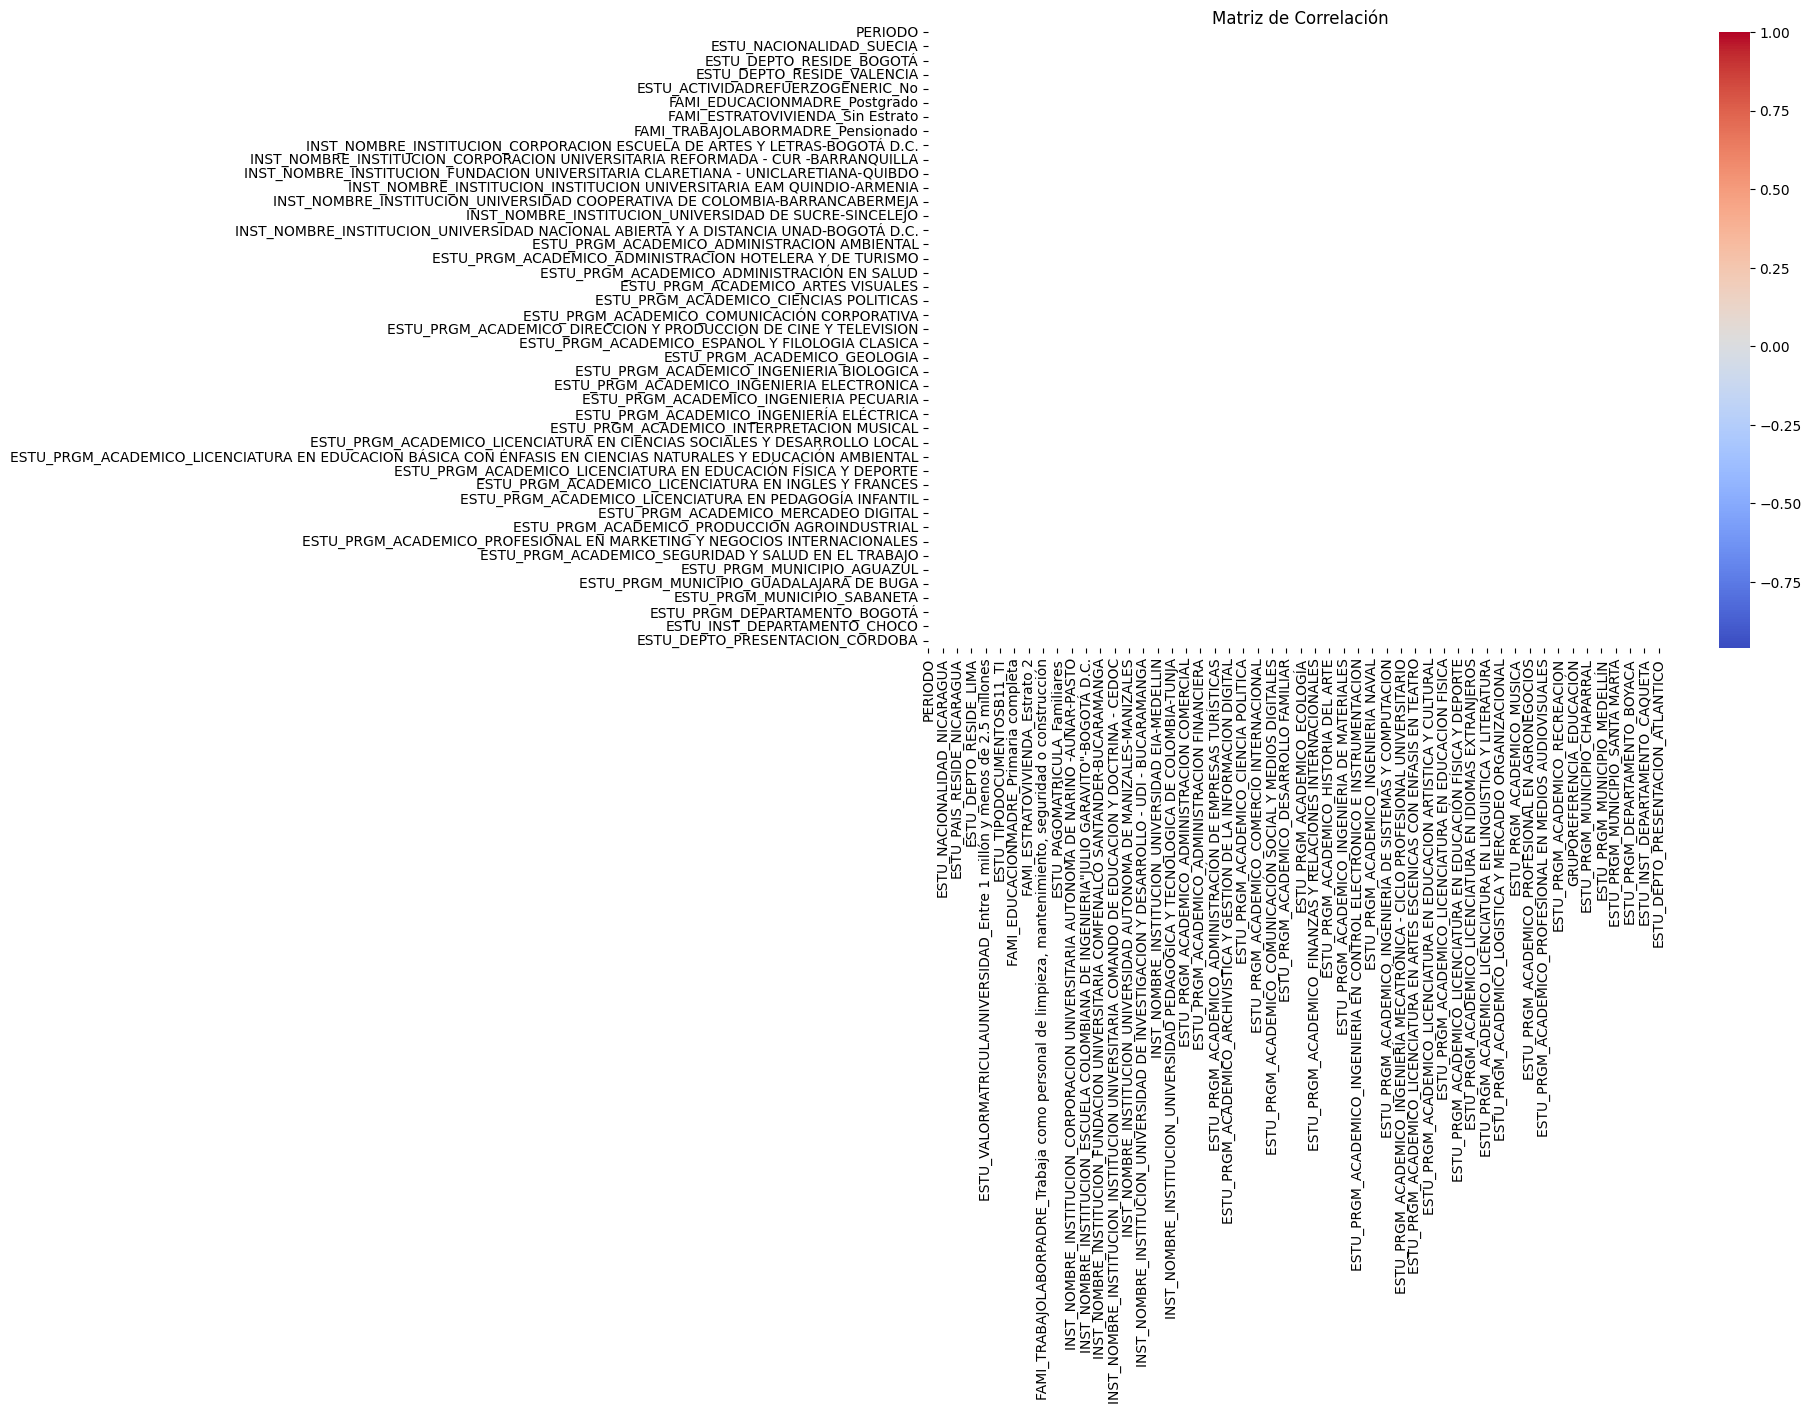

In [44]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlationMatrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

## Generación de graficos para la exploración y representación de información mas relavante.

### Generar Histogramas para cada variable en relación con 'PUNT_GLOBAL'

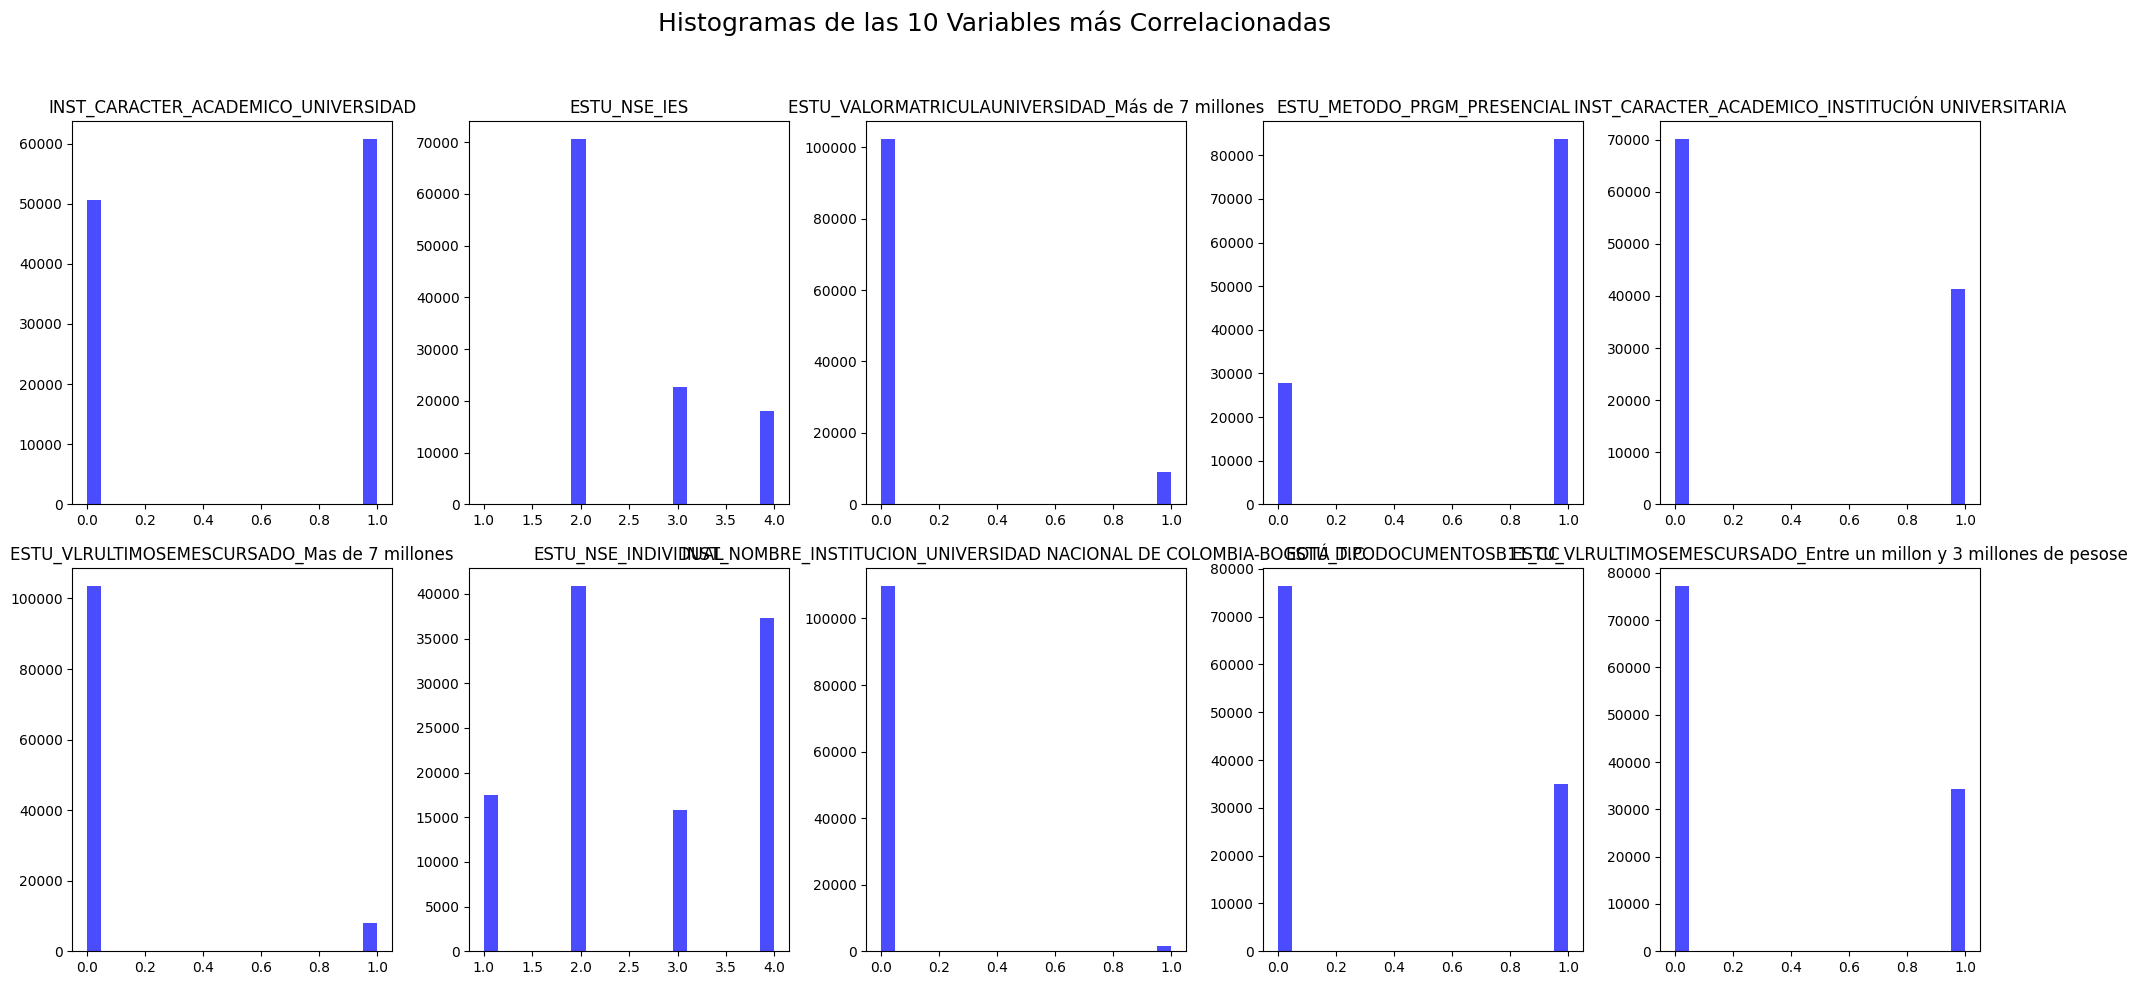

In [43]:
def formatterBoolean(variable):
    """Convierte los datos booleanos a tipo entero."""
    if variable.dtype == 'bool':  # Convertir booleanos a enteros
        return variable.astype(np.uint8)
    else:  # Rellenar datos nulos con la mediana si es necesario
        return variable.fillna(variable.median())

top10Variables = correlationMatrix['PUNT_GLOBAL'].abs().sort_values(ascending=False).head(11).index[1:]

# Configura el tamaño y distribución de los subplots (2x5)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
fig.suptitle('Histogramas de las 10 Variables más Correlacionadas', fontsize=18)

for i, var in enumerate(top10Variables):
    row, col = divmod(i, 5)  # Organiza en una cuadrícula de 2x5
    dataPreprocessed = formatterBoolean(dataWithDummies[var])  
    axes[row, col].hist(dataPreprocessed, bins=20, alpha=0.7, color='blue')
    axes[row, col].set_title(var)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para que no sobreescriba el título general
plt.show()

### Generar Boxplots para cada variable en relación con 'PUNT_GLOBAL'

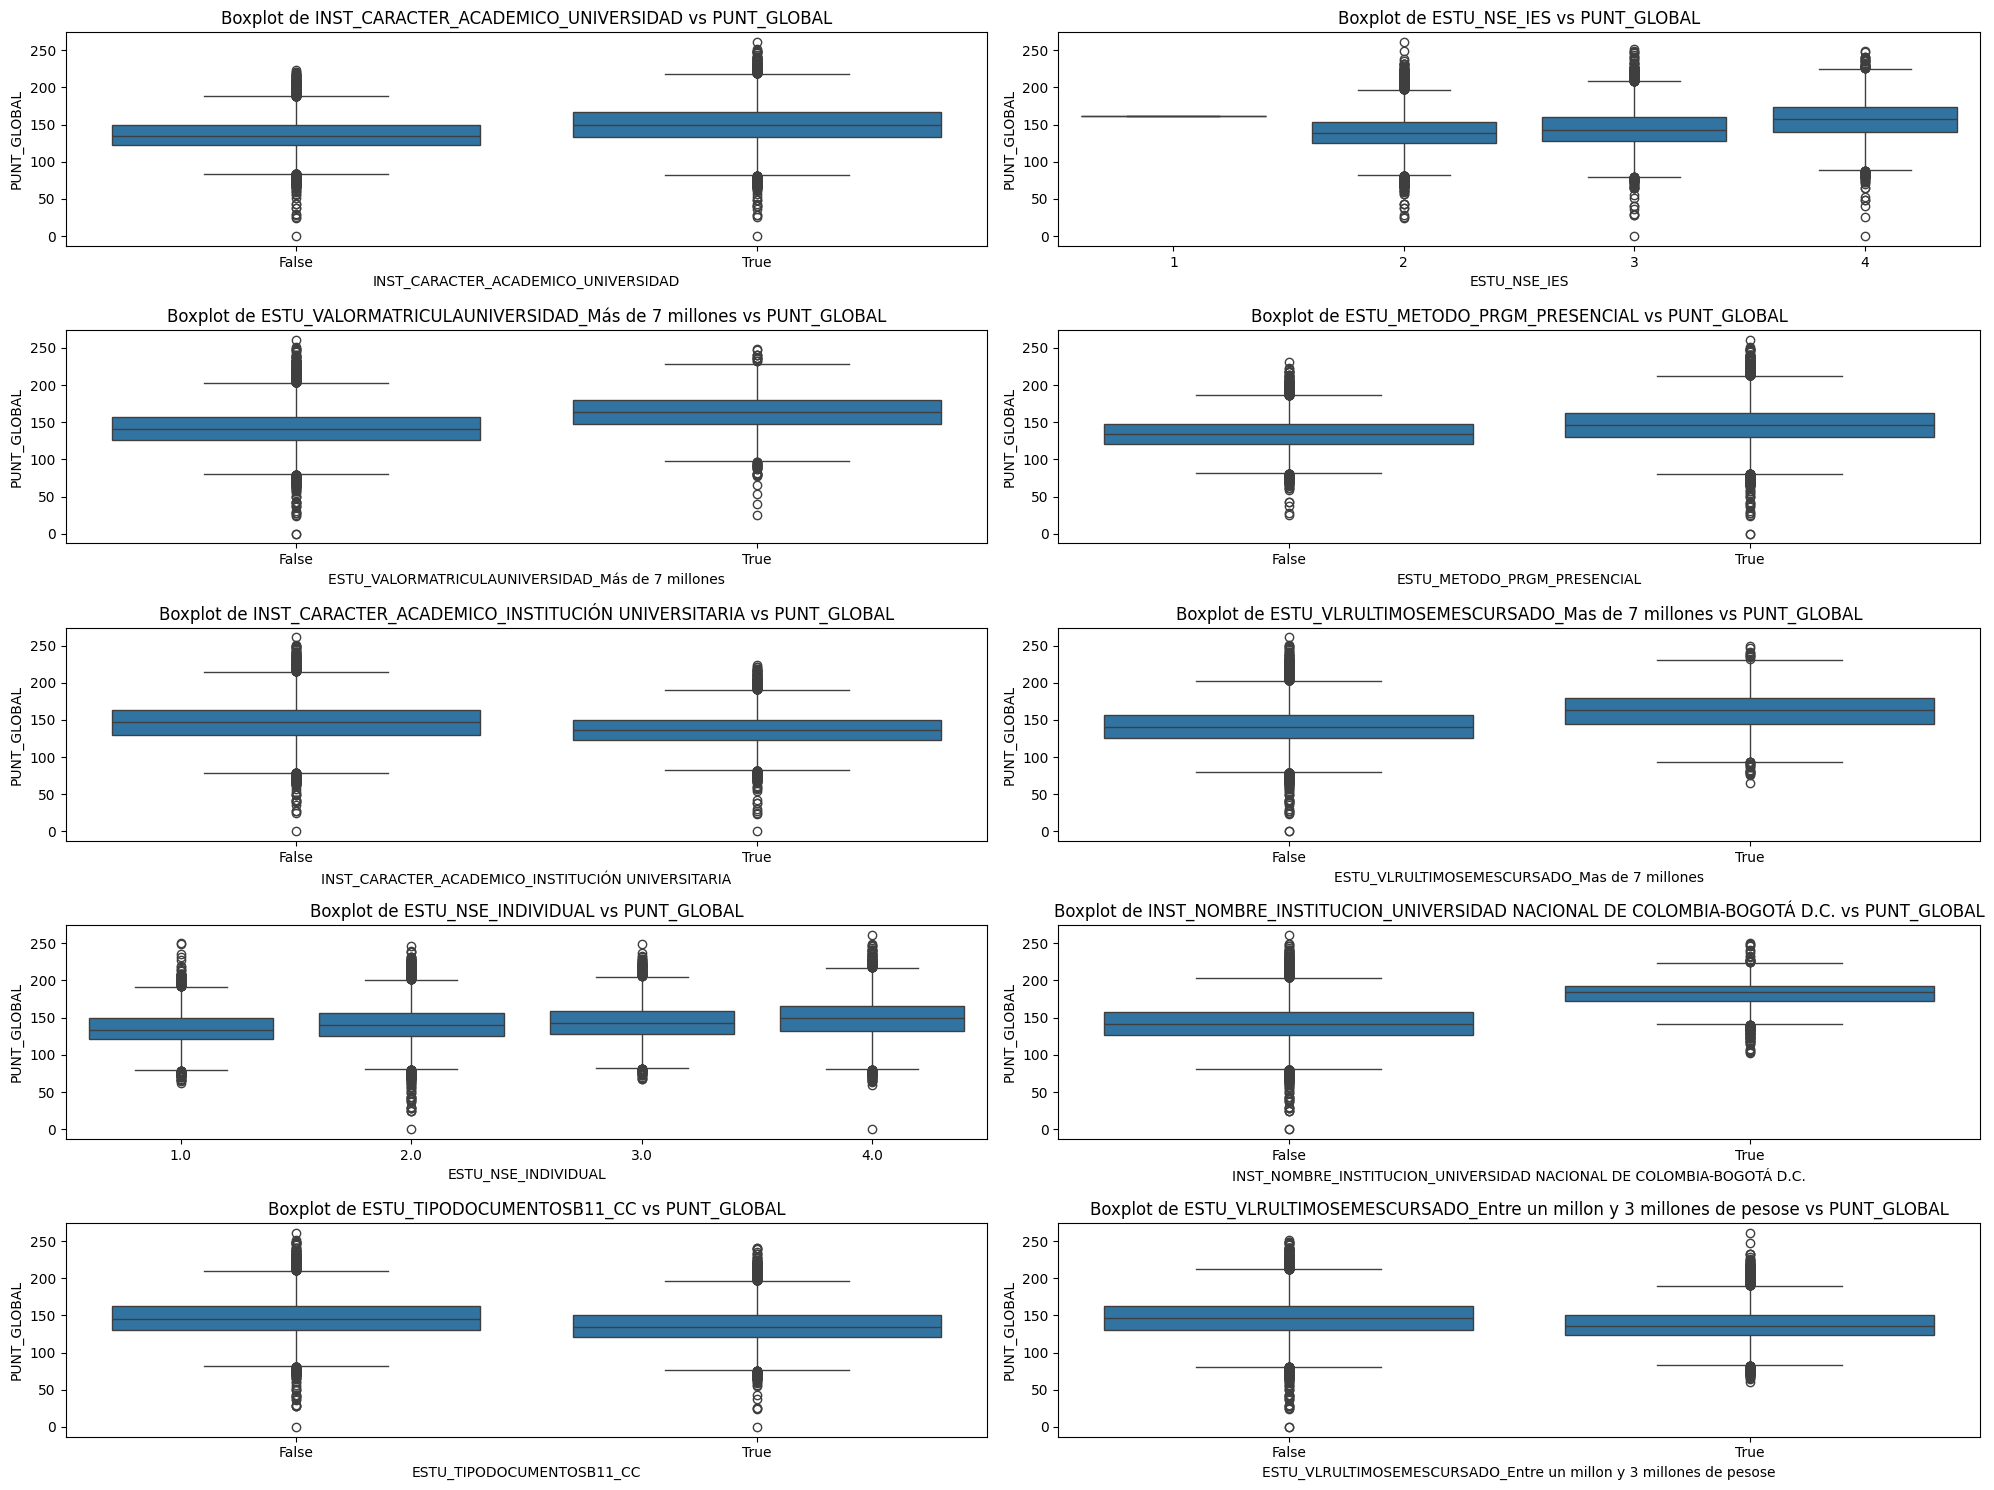

In [45]:
plt.figure(figsize=(20, 15))
for i, column in enumerate(top10Variables, 1):
    plt.subplot(5, 2, i)  # 5 filas, 2 columnas
    sns.boxplot(x=dataWithDummies[column], y=dataWithDummies['PUNT_GLOBAL'])
    plt.title(f'Boxplot de {column} vs PUNT_GLOBAL')
    plt.tight_layout()
plt.show()

### Generar Scatterplot para cada variable en relación con 'PUNT_GLOBAL'

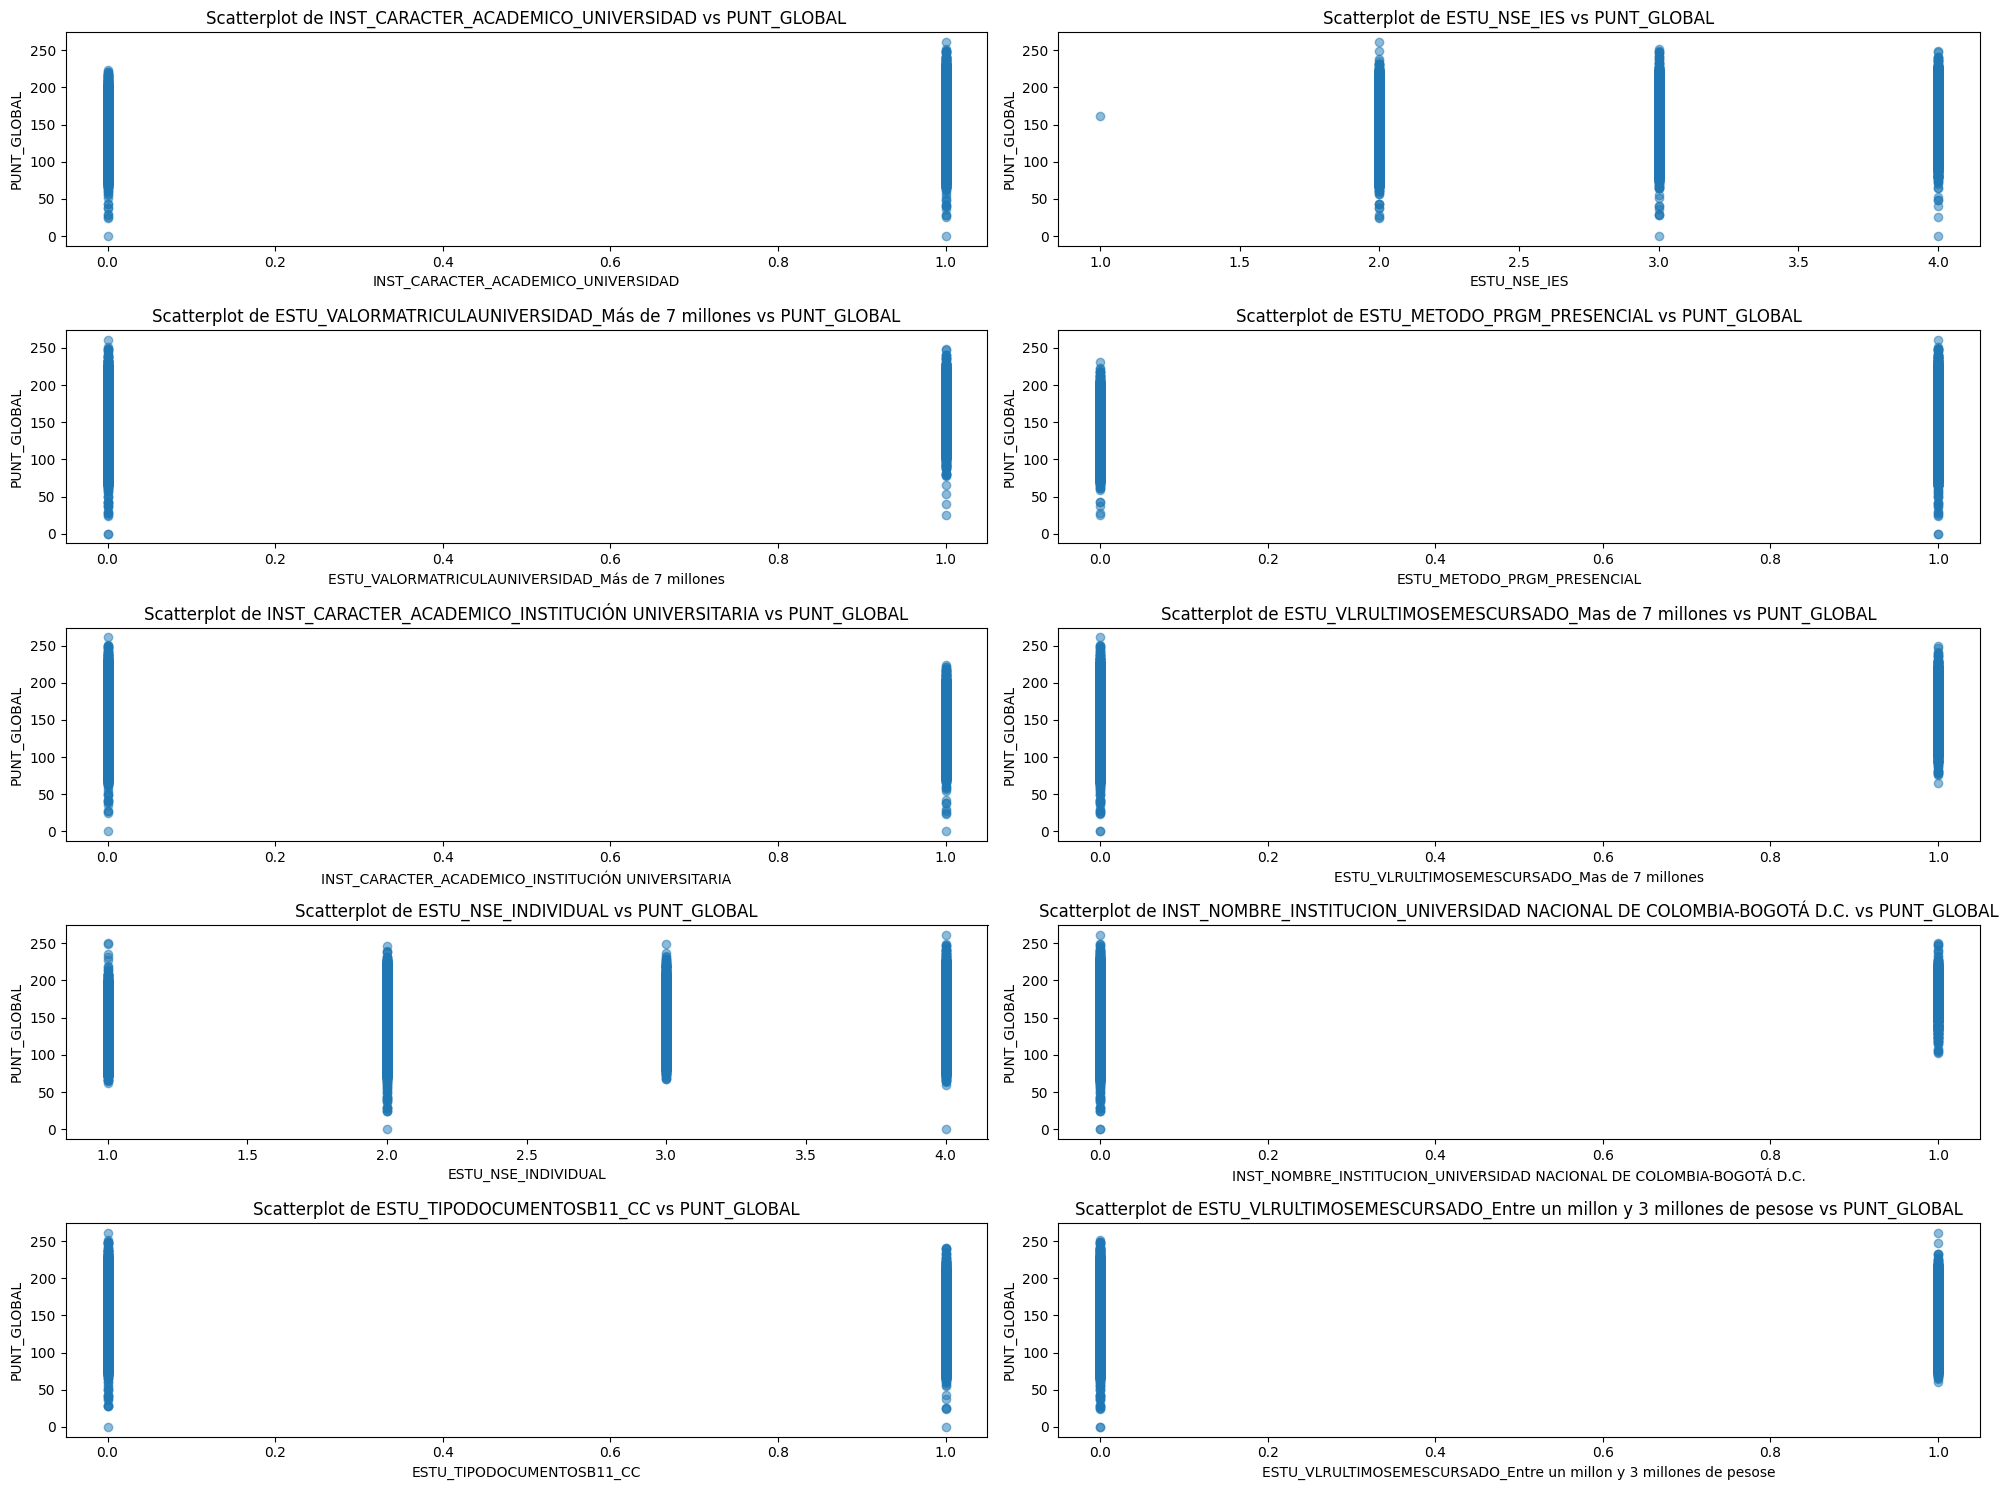

In [46]:
plt.figure(figsize=(20, 15))
for i, column in enumerate(top10Variables, 1):
    plt.subplot(5, 2, i)
    plt.scatter(dataWithDummies[column], dataWithDummies['PUNT_GLOBAL'], alpha=0.5)
    plt.title(f'Scatterplot de {column} vs PUNT_GLOBAL')
    plt.xlabel(column)
    plt.ylabel('PUNT_GLOBAL')
    plt.tight_layout()

plt.show()

### Punto 2: Separación de Datos en Entrenamiento y Prueba
Para este punto, dividimos los datos en un conjunto de entrenamiento y otro de prueba. Usaremos el 80% para entrenamiento y el 20% para prueba.

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = dataWithDummies.drop(columns=['PUNT_GLOBAL'])  # Variables predictoras
y = dataWithDummies['PUNT_GLOBAL']  # Variable objetivo

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Conjunto de entrenamiento: {XTrain.shape}, {yTrain.shape}")
print(f"Conjunto de prueba: {XTest.shape}, {yTest.shape}")

Conjunto de entrenamiento: (89144, 1610), (89144,)
Conjunto de prueba: (22286, 1610), (22286,)


## Punto 2.2 y 2.3 Entrenar modelo de regresión y obtener metricas.

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

model = LinearRegression()
model.fit(XTrain, yTrain)

# Predecir en los conjuntos de entrenamiento y prueba
yTrainPred = model.predict(XTrain)
yTestPred = model.predict(XTest)

# Calcular métricas de desempeño en entrenamiento y prueba
r2Train = r2_score(yTrain, yTrainPred)
mseTrain = mean_squared_error(yTrain, yTrainPred)
mapeTrain = mean_absolute_percentage_error(yTrain, yTrainPred)

r2Test = r2_score(yTest, yTestPred)
mseTest = mean_squared_error(yTest, yTestPred)
mapeTest = mean_absolute_percentage_error(yTest, yTestPred)

# Mostrar las métricas de desempeño
print("\nMétricas en Entrenamiento:")
print(f"R²: {r2Train}, MSE: {mseTrain}, MAPE: {mapeTrain}")

print("\nMétricas en Prueba:")
print(f"R²: {r2Test}, MSE: {mseTest}, MAPE: {mapeTest}")


Métricas en Entrenamiento:
R²: 0.4214419495580489, MSE: 317.80500991646403, MAPE: 6063907759075.154

Métricas en Prueba:
R²: 0.3982142698695549, MSE: 333.26700816021696, MAPE: 29236404289963.973


## 2.3 ¿Cual es el mejor Square?
El mejor R Square se consiguio en los datos de entrenamiento.

## Punto 4. Probar modelo con dataset de test 

### Es importante aclarar que aquí nuevamente se realiza la limpieza y formateo de los datos que se realizó anteriormente para el conjunto de datos de entrenamiento.

In [53]:
from sklearn.impute import SimpleImputer

testPath = "data/test_pruebas.csv"
dataTest = pd.read_csv(testPath, low_memory=False)

def alignsColumns(XTrain, XTest):
    """Alinea las columnas del conjunto de prueba con las del entrenamiento."""
    missingCols = list(set(XTrain.columns) - set(XTest.columns))
    extraCols = list(set(XTest.columns) - set(XTrain.columns))
    # Crear DataFrame con las columnas faltantes y valores en 0
    missingColsDf = pd.DataFrame(0, index=XTest.index, columns=missingCols)
    # Concatenar las columnas faltantes al conjunto de prueba
    XTest = pd.concat([XTest, missingColsDf], axis=1)
    # Eliminar columnas extra que no estaban en el conjunto de entrenamiento
    XTest.drop(columns=extraCols, inplace=True)
    # Asegurar que las columnas estén en el mismo orden
    XTest = XTest[XTrain.columns]
    return XTest


def imputValues(X):
    """Rellena los valores NaN con la mediana de cada columna."""
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
    return X_imputed


calculateAge(dataTest, 'ESTU_FECHANACIMIENTO')
dataTestClean = dataTest.drop(columns=columnsToDrop, errors='ignore') # Se vuelve a realizar la limpieza pero para el conjunto de datos de test
dataTestClean.fillna(2.000000, inplace=True)
dataTestWithDummies = convertADummies(dataTestClean)

def generateFile(estuConsecutivo, predicciones, filename):
    """Genera el archivo de envío para Kaggle."""
    submission = pd.DataFrame({
        'id': estuConsecutivo,
        'TARGET': predicciones
    })
    submission.to_csv(filename, index=False)
    print(f"Archivo de envío generado: {filename}")

# Antes de empezar a predecir hay que asegurarnos que los datos de train y testing si esten alineados.
XTestAligned = alignsColumns(XTrain, dataTestWithDummies)
XTestAligned = imputValues(XTestAligned)

### Punto 4. Predición del modelo con datos de test y generación de archivos

In [54]:
yTestPred = model.predict(XTestAligned)
estuConsecutivo = dataTest['ESTU_CONSECUTIVO']
generateFile(estuConsecutivo, yTestPred, 'Regression.csv') # Generar el archivo de envío para Kaggle

Archivo de envío generado: Regression.csv


### Punto 4 - Calculando MSE una vez evaluado el modelo.

El MSE obtenido en la plataforma de Kaggle es de 329.94946.
Un valor de 329.94946 implica que, en promedio, la diferencia al cuadrado entre las predicciones y los valores reales es 329.95 unidades.
El valor obtenido del MSE alto indica que las predicciones del modelo no se ajustan bien a los valores reales, lo que indica que es necesario realizar otras estrategias para mejorar la predicción del modelo o probar con otros modelos como el KNN y el GBM.
En resumen las conclusiones de este puntaje son:
- Incluir más características relevantes.
- Probar modelos más robustos.
- Eliminar outliers que puedan estar afectando la métrica.

### Punto 5: Conclusiones

### Rendimiento General del Modelo:

El valor de R² (42% para entrenamiento y 40% para prueba) indica que el modelo explica aproximadamente 40% de la varianza del objetivo (PUNT_GLOBAL). Esto no es un valor particularmente alto, lo que sugiere que hay factores adicionales no considerados en el modelo que podrían explicar el puntaje global.

**Consistencia entre Entrenamiento y Prueba:**

Los valores de MSE (317 en entrenamiento y 333 en prueba) son relativamente cercanos, lo que sugiere que el modelo no está sufriendo de sobreajuste (overfitting) severo. Sin embargo, dado que ambos errores son altos, el modelo podría beneficiarse de mejoras adicionales.
Alto MAPE:

El valor de MAPE es extremadamente alto tanto en entrenamiento como en prueba. Lo mas probable es que esto ocurra por:

Predicciones muy alejadas de los valores reales (outliers o mal ajuste).
Valores cercanos a cero en las variables objetivo, lo que amplifica el error porcentual.

## Punto 2: KNN

### Calcular resultados para cada uno de los vecinos.
Es necesario aclarar que en base a que los modelos empezaron a tomar un tiempo considerable para entrenarse, se empezo a agregar mediciones de tiempo en cada predicción con el fin de intentar encontrar la foma de optimizar estos modelos y/o brindar un mejor analisis de la implementación y solución del problema.

### Ajustes adicionales al modelo de KNN.

Dado el tamaño del dataset y la lentitud observada durante las búsquedas, se decidió optimizar el modelo de **K-Nearest Neighbors (KNN)** mediante el uso del algoritmo **kd-tree**. Este algoritmo es una estructura de datos que mejora la eficiencia al organizar los puntos de datos en un árbol binario, lo que permite realizar búsquedas de vecinos más cercanos de manera más rápida y eficiente, especialmente en datasets con varias dimensiones.

Además, se implementó el parámetro **n_jobs=-1**, que habilita la paralelización del proceso. Esto significa que el modelo utiliza todos los núcleos disponibles en la CPU, permitiendo que las búsquedas de vecinos se realicen en paralelo. Como resultado, esto mejora significativamente la velocidad de entrenamiento y predicción del modelo, aprovechando al máximo los recursos del sistema. Esta configuración resulto beneficiosa cuando se proboran los varios valores de vecinos (n_neighbors), ya que redujo el tiempo total de procesamiento al de la primera prueba con el modelo de KNN a fuerza bruta.

In [24]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import time

neighbors = [5, 10, 20, 30]
results = []

for n in neighbors:
    print(f"\nEvaluando KNN con {n} vecinos...")

    # Medir el tiempo de entrenamiento del modelo.
    start_time = time.time()

    # Definir y entrenar el modelo KNN
    knn = KNeighborsRegressor(n_neighbors=n, algorithm='kd_tree', n_jobs=-1)
    knn.fit(XTrain, yTrain)

    # Hacer predicciones en los conjuntos de entrenamiento y prueba
    yTrainPred = knn.predict(XTrain)
    yTestPred = knn.predict(XTest)

    # Calcular métricas para entrenamiento y prueba
    mseTrain = mean_squared_error(yTrain, yTrainPred)
    mapeTrain = mean_absolute_percentage_error(yTrain, yTrainPred)
    mseTest = mean_squared_error(yTest, yTestPred)
    mapeTest = mean_absolute_percentage_error(yTest, yTestPred)

    # Medir el tiempo final y calcular tiempo transcurrido
    elapsed_time = time.time() - start_time

    # Almacenar los resultados
    results.append({
        'n_neighbors': n,
        'MSE_Train': mseTrain,
        'MAPE_Train': mapeTrain,
        'MSE_Test': mseTest,
        'MAPE_Test': mapeTest,
        'Time': elapsed_time
    })

    # Imprimir resultados parciales
    print(f"Vecinos: {n}, MSE_Train: {mseTrain}, MSE_Test: {mseTest}, Tiempo: {elapsed_time:.2f} segundos")

# Convertir los resultados a DataFrame para visualización
resultsDf = pd.DataFrame(results)
print("\nResultados finales:")
print(resultsDf)


Evaluando KNN con 5 vecinos...
Vecinos: 5, MSE_Train: 288.24497352598047, MSE_Test: 439.82364354303144, Tiempo: 538.15 segundos

Evaluando KNN con 10 vecinos...
Vecinos: 10, MSE_Train: 330.6868885174549, MSE_Test: 412.0237305931975, Tiempo: 572.05 segundos

Evaluando KNN con 20 vecinos...
Vecinos: 20, MSE_Train: 358.61714930337433, MSE_Test: 402.0744932917526, Tiempo: 547.85 segundos

Evaluando KNN con 30 vecinos...
Vecinos: 30, MSE_Train: 371.04203358860076, MSE_Test: 402.05419456160814, Tiempo: 547.01 segundos

Resultados finales:
   n_neighbors   MSE_Train    MAPE_Train    MSE_Test     MAPE_Test        Time
0            5  288.244974  6.294855e+12  439.823644  2.918064e+13  538.154902
1           10  330.686889  6.229178e+12  412.023731  2.920085e+13  572.052803
2           20  358.617149  7.045084e+12  402.074493  3.005970e+13  547.854937
3           30  371.042034  7.162123e+12  402.054195  3.052786e+13  547.006665


### 
Metricas para cada KNN.

| n_neighbors |  MSE_Train  |   MAPE_Train   |   MSE_Test   |   MAPE_Test   |
|-------------|-------------|----------------|--------------|---------------|
|      5      | 288.244974  | 6.294855e+12   | 439.823644   | 2.918064e+13  |
|     10      | 330.686889  | 6.229178e+12   | 412.023731   | 2.920085e+13  |
|     20      | 358.617149  | 7.045084e+12   | 402.074493   | 3.005970e+13  |
|     30      | 371.042034  | 7.162123e+12   | 402.054195   | 3.052786e+13  |

### En base a los resultados seleccionaremos el mejor modelo.

In [25]:
bestModel = resultsDf.loc[resultsDf['MSE_Test'].idxmin()]
bestNeighbors = bestModel['n_neighbors']

print(f"El mejor número de vecinos es: {bestNeighbors}")

El mejor número de vecinos es: 30.0


### Definir y entrenar el mejor modelo KNN con el número óptimo de vecinos
Una vez obtenido el mejor vecino procederemos a entrenar el modelo y a generar el archivo para subir a la compentencia.

In [26]:
bestKnn = KNeighborsRegressor(n_neighbors=int(bestNeighbors), algorithm='kd_tree', n_jobs=-1)
bestKnn.fit(XTrain, yTrain)

KNeighborsRegressor(algorithm='kd_tree', n_jobs=-1, n_neighbors=30)

In [27]:
start_time = time.time()
yTestPred = bestKnn.predict(XTestAligned)
elapsed_time = time.time() - start_time
generateFile(estuConsecutivo, yTestPred, filename=f"KNN_{bestNeighbors}.csv")
print(f"Tiempo de predicción: {elapsed_time:.2f} segundos")

Archivo de envío generado: KNN_30.0.csv
Tiempo de predicción: 120.21 segundos


## Punto 3 - GBM

### Entrenar modelo

En las pruebas de entrenamiento del modelo, se identificó que, subiendo la cantidad máxima de iteraciones a 400, el modelo presentaba mejores resultados que con respecto a las iteraciones máximas por defecto.

In [14]:
from sklearn.ensemble import HistGradientBoostingRegressor
import time

print("Entrenando modelo GBM...")
start_time = time.time()
gbm = HistGradientBoostingRegressor(random_state=42,max_iter=400)
gbm.fit(XTrain, yTrain)

elapsed_time = time.time() - start_time
print(f"Tiempo de entrenamiento: {elapsed_time:.2f} segundos")

Entrenando modelo GBM...
Tiempo de entrenamiento: 101.48 segundos


In [15]:
yTrainPred = gbm.predict(XTrain)
yTestPred = gbm.predict(XTest)

r2Train = r2_score(yTrain, yTrainPred)
mseTrain = mean_squared_error(yTrain, yTrainPred)
mapeTrain = mean_absolute_percentage_error(yTrain, yTrainPred)
mseTest = mean_squared_error(yTest, yTestPred)
mapeTest = mean_absolute_percentage_error(yTest, yTestPred)
r2Train = r2_score(yTest, yTestPred)

print("\nMétricas en Entrenamiento:")
print(f"R²: {r2Train}, MSE: {mseTrain}, MAPE: {mapeTrain}")
print("\nMétricas en Prueba:")
print(f"R²: {r2Train}, MSE: {mseTest}, MAPE: {mapeTest}")


Métricas en Entrenamiento:
R²: 0.40264220269256956, MSE: 300.33945136735, MAPE: 6322663636243.243

Métricas en Prueba:
R²: 0.40264220269256956, MSE: 330.8148331577611, MAPE: 29146900639300.324


In [55]:
start_time = time.time()
yTestPred = gbm.predict(XTestAligned)
elapsed_time = time.time() - start_time
print(f"Tiempo de entrenamiento: {elapsed_time:.2f} segundos")
generateFile(estuConsecutivo, yTestPred, filename="GBM.csv")

Tiempo de entrenamiento: 0.49 segundos
Archivo de envío generado: GBM.csv
